# Data Description:
Thedataset has 60000 images in training set and 10000 images in test set. The images are from MNIST dataset.

The MNIST digits dataset is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

# Import Libraries

In [1]:
# Numpy
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf

import random

import cv2

In [2]:
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
tf.__version__

'2.2.0-rc3'

# Load the dataset

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
# Check the distant target image labels
img_labels = set(y_train)
img_labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Visualize the images in the dataset

Since the dataset contains different images for digits 0-9. We will visualize 1 image per digit taken at random from the dataset

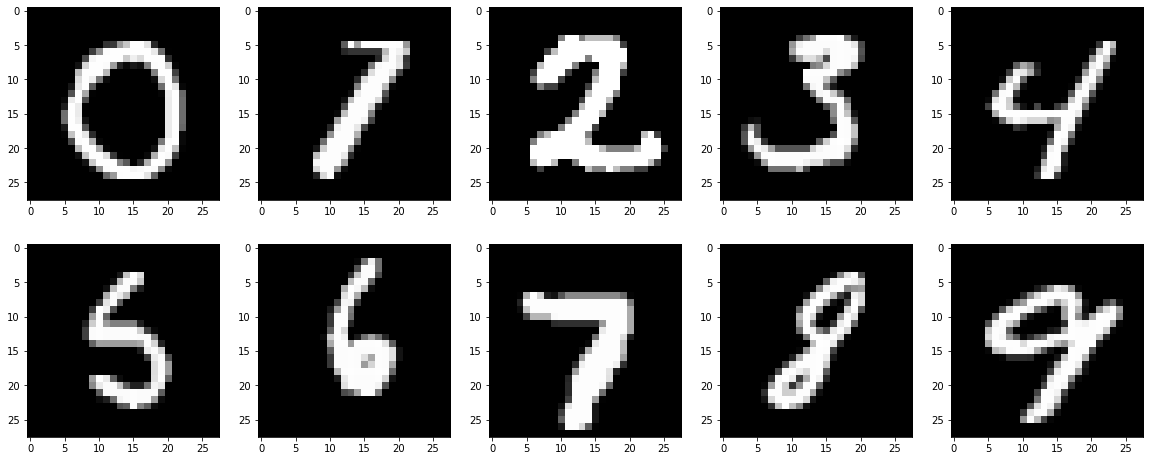

In [6]:
def random_visualize(img_data, img_labels):
    fig = plt.figure(figsize=(20, 8))
    counter = 1
    for digit in img_labels:
        plt.subplot(2,5,counter)
        counter += 1
        rand_img = random.choice(np.where((y_train==digit))[0])
        plt.imshow(img_data[rand_img], cmap='gray')

random_visualize(X_train, img_labels)

# Data preprocessing

In [7]:
blurrer = lambda x: cv2.GaussianBlur(x, (3, 3), 0)

X_train_blur = np.array([blurrer(xi) for xi in X_train])
X_test_blur = np.array([blurrer(xi) for xi in X_test])

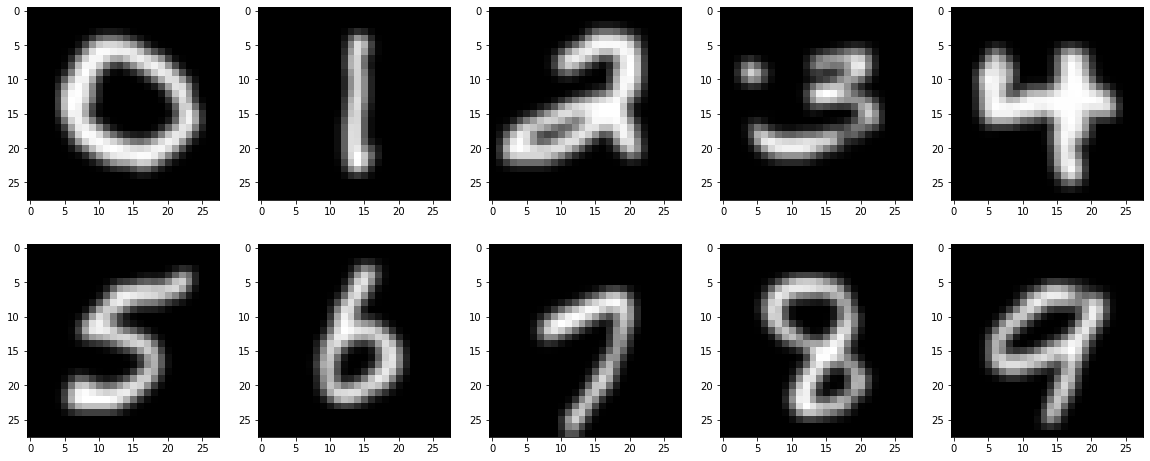

In [8]:
random_visualize(X_train_blur, img_labels)

In [9]:
# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train_blur = X_train_blur.reshape(X_train_blur.shape[0], 28, 28, 1)
X_test_blur = X_test_blur.reshape(X_test_blur.shape[0], 28, 28, 1)

In [10]:
# Scale the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Scale the blurred data
X_train_blur = X_train_blur.astype('float32')
X_test_blur = X_test_blur.astype('float32')
X_train_blur /= 255
X_test_blur /= 255

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Convolutional neural network

## 1. Model architecture

In [12]:
# Model
def build_model():
    model = tf.keras.models.Sequential(layers = [
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(X_train.shape[1:])),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"), 
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
    return model

In [13]:
lst_callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5), 
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
]

# 2. Fit model on normal data (not blurred)

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [15]:
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=50, validation_data=(X_test, y_test), callbacks=lst_callback)

Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9341
Epoch 00001: val_loss improved from inf to 0.05798, saving model to best_model.h5
235/235 [==============================] - 42s 180ms/step - loss: 0.2312 - accuracy: 0.9341 - val_loss: 0.0580 - val_accuracy: 0.9803
Epoch 2/50
235/235 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9812
Epoch 00002: val_loss improved from 0.05798 to 0.04588, saving model to best_model.h5
235/235 [==============================] - 39s 167ms/step - loss: 0.0599 - accuracy: 0.9812 - val_loss: 0.0459 - val_accuracy: 0.9849
Epoch 3/50
235/235 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9877
Epoch 00003: val_loss improved from 0.04588 to 0.03450, saving model to best_model.h5
235/235 [==============================] - 39s 167ms/step - loss: 0.0398 - accuracy: 0.9877 - val_loss: 0.0345 - val_accuracy: 0.9872
Epoch 4/50
235/235 [==============================] - ET

In [16]:
model = tf.keras.models.load_model("best_model.h5")

In [17]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0309 - accuracy: 0.9905


[0.03086051158607006, 0.9904999732971191]

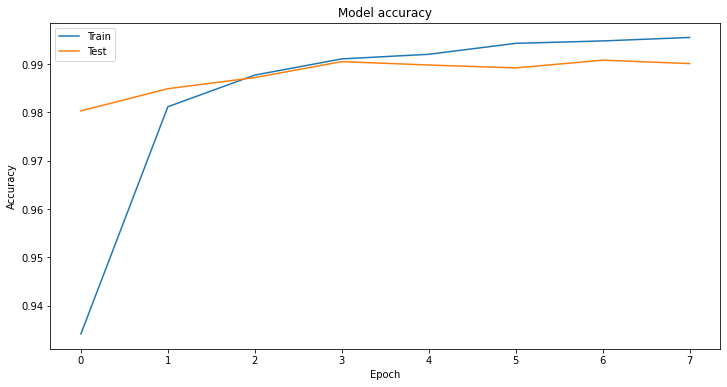

In [18]:
def build_history_plot(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
build_history_plot(history)

## 3. Fit model on blurred images

In [19]:
blur_model = build_model()
blur_model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
blur_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [20]:
history = blur_model.fit(x=X_train_blur, y=y_train, batch_size=256, epochs=50, validation_data=(X_test_blur, y_test), callbacks=lst_callback)

Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.9256
Epoch 00001: val_loss did not improve from 0.03020
235/235 [==============================] - 42s 178ms/step - loss: 0.2596 - accuracy: 0.9256 - val_loss: 0.0718 - val_accuracy: 0.9771
Epoch 2/50
235/235 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9787
Epoch 00002: val_loss did not improve from 0.03020
235/235 [==============================] - 42s 180ms/step - loss: 0.0690 - accuracy: 0.9787 - val_loss: 0.0472 - val_accuracy: 0.9835
Epoch 3/50
235/235 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9849
Epoch 00003: val_loss did not improve from 0.03020
235/235 [==============================] - 42s 180ms/step - loss: 0.0491 - accuracy: 0.9849 - val_loss: 0.0390 - val_accuracy: 0.9854
Epoch 4/50
235/235 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9885
Epoch 00004: val_loss did not improve from 0.03020
235/235 [=

In [21]:
blur_model = tf.keras.models.load_model("best_model.h5")

In [22]:
blur_model.evaluate(X_test_blur, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0277 - accuracy: 0.9897


[0.02774357795715332, 0.9897000193595886]

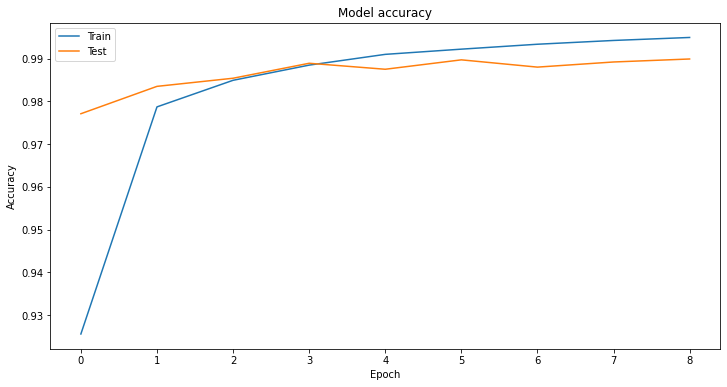

In [23]:
build_history_plot(history)

# Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. (5 Marks)

## 1. Normal model|

In [24]:
y_pred = model.predict(X_test)

In [25]:
X_test = X_test.reshape(X_test.shape[0], 28, 28)

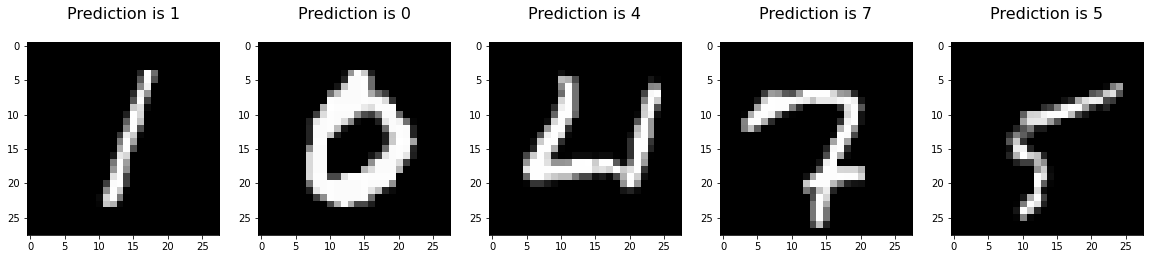

In [26]:
fig = plt.figure(figsize=(20, 12))
counter = 1
for index in [2, 3, 33, 36, 59]:
    plt.subplot(1,5,counter)
    counter += 1
    plt.imshow(X_test[index], cmap='gray')
    plt.title("Prediction is {}\n".format(np.argmax(y_pred[index])), fontsize=16)

## 2. Blur model

In [27]:
y_pred = blur_model.predict(X_test_blur)
X_test_blur = X_test_blur.reshape(X_test_blur.shape[0], 28, 28)

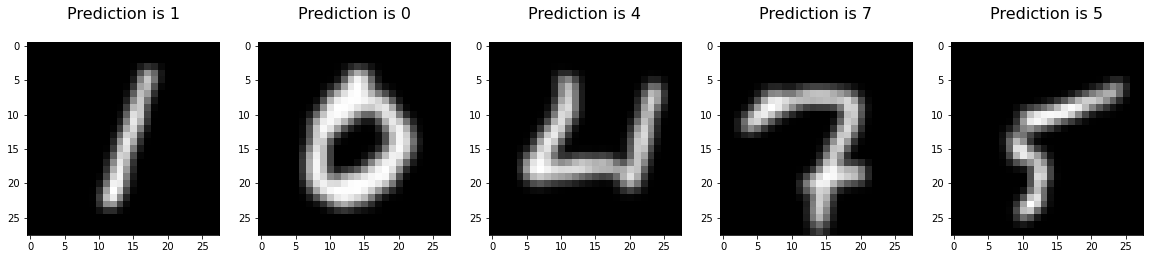

In [28]:
fig = plt.figure(figsize=(20, 12))
counter = 1
for index in [2, 3, 33, 36, 59]:
    plt.subplot(1,5,counter)
    counter += 1
    plt.imshow(X_test_blur[index], cmap='gray')
    plt.title("Prediction is {}\n".format(np.argmax(y_pred[index])), fontsize=16)

# Conclusion

- 99% accuracy is obtained with normal provided images
- 98.9% accuracy is obtained for model trained with blurred images
- The model fitted on blurred images converges a little faster than normal images